In [1]:
# =============================================================================
# UNIVERSAL STIM DISCOVERY 
# =============================================================================

import os
import re
import mne
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET


datasets = {
    'bima_off': {
        'data_dir': "/home/jaizor/jaizor/xtra/data/PD_Bima",
        'filename_pattern': r"PD_(\d{3})_bima_DBSOFF\.mff"  
    },
    'rest_on': {
        'data_dir': "/home/jaizor/jaizor/xtra/data/PD_Rest/ON",
        'filename_pattern': r"PD_(\d{3})_rest_hand_foot_DBSON\.mff"
    },
    'rest_off': {
        'data_dir': "/home/jaizor/jaizor/xtra/data/PD_Rest/OFF",
        'filename_pattern': r"PD_(\d{3})_rest_hand_foot_DBSOFF\.mff"
    }}


# Define helper functions

def discover_stim_events(
    data_dir: str,
    filename_pattern: str,
    subject_format: str = "sub-{id:02d}",
    file_extension: str = ".mff") -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Discover stim channels and events in any dataset.
    """
    # Find subjects
    subjects = []
    compiled_pattern = re.compile(filename_pattern)
    for fname in os.listdir(data_dir):
        if not fname.endswith(file_extension):
            continue
        match = compiled_pattern.match(fname)
        if match:
            subj_num = int(match.group(1))
            subjects.append(subject_format.format(id=subj_num))
    
    if not subjects:
        print(f"⚠️ No files matching pattern found in {data_dir}")
        return pd.DataFrame(), pd.DataFrame()
    
    subjects = sorted(subjects, key=lambda x: int(re.search(r'\d+', x).group()))
    print(f"📁 Found {len(subjects)} subjects: {subjects}")
    
    # Helper functions
    def find_stim_channels(raw):
        stim_candidates = []
        for ch_name, ch_type in zip(raw.ch_names, raw.get_channel_types()):
            if ch_type in ['stim', 'misc']:
                stim_candidates.append(ch_name)
            elif any(kw in ch_name.upper() for kw in ['STI', 'TRIG', 'TTL']):
                stim_candidates.append(ch_name)
            elif ch_name[0].isdigit() and len(ch_name) <= 3:
                stim_candidates.append(ch_name)
        return sorted(set(stim_candidates))
    
    def extract_events(raw, stim_channels):
        events = []
        sfreq = raw.info['sfreq']
        for ch in stim_channels:
            if ch not in raw.ch_names:
                continue
            data = raw.get_data(picks=[ch])[0]
            digital = (data > 0.5).astype(int)
            diff = np.diff(digital, prepend=0)
            onset_samples = np.where(diff == 1)[0]
            onset_times = onset_samples / sfreq
            for t, s in zip(onset_times, onset_samples):
                events.append({
                    'subject': None,
                    'channel': ch,
                    'time_sec': t,
                    'sample': int(s),
                    'sfreq': sfreq
                })
        return pd.DataFrame(events) if events else pd.DataFrame()
    
    # Process subjects
    all_events_list = []
    subject_summaries = []
    
    for sub in tqdm(subjects, desc="Discovering Stim Events"):
        try:
            subj_num = int(re.search(r'\d+', sub).group())
            
            # Find matching file (more robust than reconstructing)
            matching_files = []
            for f in os.listdir(data_dir):
                if f.endswith(file_extension) and compiled_pattern.match(f):
                    if str(subj_num).zfill(3) in f:  # crude but effective
                        matching_files.append(f)
            
            if not matching_files:
                print(f"⚠️ No file found for {sub}")
                continue
                
            mff_path = os.path.join(data_dir, matching_files[0])
            raw = mne.io.read_raw_egi(mff_path, preload=True, verbose=False)
            
            stim_channels = find_stim_channels(raw)
            events_df = extract_events(raw, stim_channels)
            
            if not events_df.empty:
                events_df['subject'] = sub
                all_events_list.append(events_df)
            
            # Build summary
            summary = {
                'subject': sub,
                'duration_sec': raw.times[-1],
                'sfreq': raw.info['sfreq'],
                'stim_channels': ';'.join(stim_channels),
                'n_channels': len(stim_channels),
                'n_events': len(events_df)
            }
            
            if not events_df.empty:
                channel_counts = events_df['channel'].value_counts()
                for ch, count in channel_counts.items():
                    summary[f'events_{ch}'] = count
                summary['first_event'] = events_df['time_sec'].min()
                summary['last_event'] = events_df['time_sec'].max()
                if len(events_df) > 1:
                    gaps = np.diff(np.sort(events_df['time_sec']))
                    summary['min_gap'] = gaps.min()
                    summary['max_gap'] = gaps.max()
                    summary['median_gap'] = np.median(gaps)
                else:
                    summary.update({k: np.nan for k in ['min_gap', 'max_gap', 'median_gap']})
            else:
                summary.update({k: np.nan for k in ['first_event', 'last_event', 'min_gap', 'max_gap', 'median_gap']})
            
            subject_summaries.append(summary)
            print(f"✅ {sub}: {len(stim_channels)} channels, {len(events_df)} events")
            
        except Exception as e:
            print(f"❌ {sub}: {e}")
    
    all_events_df = pd.concat(all_events_list, ignore_index=True) if all_events_list else pd.DataFrame()
    summary_df = pd.DataFrame(subject_summaries) if subject_summaries else pd.DataFrame()
    
    return all_events_df, summary_df

def plot_stim_events(subject_id, events_df, figsize=(12, 4)):
    sub_events = events_df[events_df['subject'] == subject_id]
    
    if sub_events.empty:
        print(f"⚠️ No events found for {subject_id}")
        return
    
    plt.figure(figsize=figsize)
    for ch in sub_events['channel'].unique():
        ch_events = sub_events[sub_events['channel'] == ch]
        plt.scatter(ch_events['time_sec'], [ch] * len(ch_events), label=ch, alpha=0.7)
    
    plt.title(f"Stim Events for {subject_id}")
    plt.xlabel("Time (s)")
    plt.ylabel("Channel")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def clean_mff_events_with_namespace(
    mff_directory: str,
    trigger_code: str = 'TT140') -> str:
    """
    Clean EGI .mff XML events by removing events before first trigger occurrence.
    Properly handles XML namespaces.
    """
    namespace = {'ns': 'http://www.egi.com/event_mff'}
    
    # Find the Events XML file
    event_xml_path = os.path.join(mff_directory, "Events_ttl_event.xml")
    if not os.path.exists(event_xml_path):
        raise FileNotFoundError(f"Events_ttl_event.xml not found in {mff_directory}")
    
    print(f"✅ Found event file: Events_ttl_event.xml")
    
    # Parse the XML with namespace
    tree = ET.parse(event_xml_path)
    root = tree.getroot()
    
    # Find all events using namespace
    event_elements = root.findall('.//ns:event', namespace)
    
    # Extract event data
    events = []
    for event_elem in event_elements:
        code_elem = event_elem.find('ns:code', namespace)
        time_elem = event_elem.find('ns:relativeBeginTime', namespace)
        if code_elem is not None and time_elem is not None:
            events.append({
                'element': event_elem,
                'code': code_elem.text,
                'relative_time': int(time_elem.text),
                'time_seconds': int(time_elem.text) / 1_000_000
            })
    
    print(f"📋 Total events found: {len(events)}")
    
    # Check if trigger exists
    trigger_events = [e for e in events if e['code'] == trigger_code]
    if not trigger_events:
        raise ValueError(f"Trigger code '{trigger_code}' not found in events!")
    
    # Find first occurrence of trigger
    first_trigger_time = min(e['relative_time'] for e in events if e['code'] == trigger_code)
    first_trigger_seconds = first_trigger_time / 1_000_000
    
    print(f"⏱️ First '{trigger_code}' at {first_trigger_seconds:.3f}s (relative time: {first_trigger_time})")
    
    # Remove events before first trigger
    events_to_remove = [e for e in events if e['relative_time'] < first_trigger_time]
    
    print(f"🧹 Removing {len(events_to_remove)} events before first '{trigger_code}':")
    for event in events_to_remove[:10]:  # Show first 10
        print(f"   - {event['code']} at {event['time_seconds']:.3f}s")
    if len(events_to_remove) > 10:
        print(f"   ... and {len(events_to_remove)-10} more")
    
    # Remove from XML
    for event_data in events_to_remove:
        root.remove(event_data['element'])
    
    # Save cleaned XML
    cleaned_xml_path = event_xml_path.replace('.xml', '_cleaned.xml')
    tree.write(cleaned_xml_path, encoding='utf-8', xml_declaration=True)
    print(f"💾 Saved cleaned events to: {os.path.basename(cleaned_xml_path)}")
    
    return cleaned_xml_path



# Group events into trials

def group_events_into_trials(events_df, trial_gap_threshold=3.0, merge_window=1.0):
    """
    Merge events within merge_window seconds and group remaining events into trials.
    
    CORRECTED LOGIC:
    - Merges consecutive same-channel events within merge_window
    - Groups events into trials based on 1a→6a/8a sequences
    - A trial starts with 1a and ends with the last 6a/8a in the sequence
    
    Parameters:
    - events_df: Original events DataFrame
    - trial_gap_threshold: Gap > X seconds = new trial (default 3.0s)
    - merge_window: Consecutive same-channel events within X seconds = merge (default 1.0s)
    
    Returns:
    - merged_events_with_trials: Merged events with trial assignments
    - trials_df: Trial structure summary
    """
    if events_df.empty:
        return pd.DataFrame(), pd.DataFrame()
    
    all_merged_events_with_trials = []
    all_trials_list = []
    
    for subject in events_df['subject'].unique():
        sub_events = events_df[events_df['subject'] == subject].copy()
        sub_events = sub_events.sort_values('time_sec').reset_index(drop=True)
        
        # Step 1: CORRECTLY merge consecutive same-channel events within merge_window
        merged_events = []
        
        # Group events by channel first (within this subject)
        for channel in sub_events['channel'].unique():
            channel_events = sub_events[sub_events['channel'] == channel].copy()
            channel_events = channel_events.sort_values('time_sec').reset_index(drop=True)
            
            i = 0
            while i < len(channel_events):
                j = i + 1
                # Extend the group as long as consecutive gaps are within merge_window
                while j < len(channel_events):
                    gap = channel_events.iloc[j]['time_sec'] - channel_events.iloc[j-1]['time_sec']
                    if gap <= merge_window:
                        j += 1
                    else:
                        break
                
                # Merge events from i to j-1
                group = channel_events.iloc[i:j]
                merged_event = {
                    'subject': group['subject'].iloc[0],
                    'channel': channel,
                    'time_sec': group['time_sec'].iloc[0],  # first time in the group
                    'sample': group['sample'].iloc[0],      # first sample in the group
                    'sfreq': group['sfreq'].iloc[0],
                    'merged_count': len(group)              # number of original events merged
                }
                merged_events.append(merged_event)
                i = j  # move to the next unprocessed event in this channel
        
        if not merged_events:
            continue
            
        # Create merged DataFrame and sort by time
        merged_df = pd.DataFrame(merged_events)
        merged_df = merged_df.sort_values('time_sec').reset_index(drop=True)
        
        # Step 2: Group merged events into trials based on 1a→6a/8a sequences
        # Find all 1a events
        one_a_indices = merged_df[merged_df['channel'] == '1a'].index.tolist()
        
        if not one_a_indices:
            # No trials found — assign trial 0
            merged_df['trial_number'] = 0
            all_merged_events_with_trials.append(merged_df)
            continue
        
        # Assign trial numbers: everything from 1a[i] to the last 6a/8a before 1a[i+1] = trial i+1
        trial_assignment = np.zeros(len(merged_df), dtype=int)
        trial_num = 1
        
        for i, start_idx in enumerate(one_a_indices):
            # Find the end of this trial (last 6a or 8a before next 1a)
            if i == len(one_a_indices) - 1:
                # Last trial: from this 1a to end
                end_idx = len(merged_df) - 1
            else:
                # Next 1a index
                next_start = one_a_indices[i + 1]
                # Find last 6a or 8a before next 1a
                potential_end = merged_df.loc[start_idx:next_start-1, 'channel'].isin(['6a', '8a'])
                if potential_end.any():
                    end_idx = potential_end[potential_end].index[-1]
                else:
                    # If no 6a/8a, use the last event before next 1a
                    end_idx = next_start - 1
            
            # Assign trial number to all events from start_idx to end_idx
            trial_assignment[start_idx:end_idx+1] = trial_num
            trial_num += 1
        
        merged_df['trial_number'] = trial_assignment
        
        # Step 3: Create trial summary
        for trial_num in sorted(merged_df['trial_number'].unique()):
            if trial_num == 0:
                continue  # skip non-trial events
            
            trial_events = merged_df[merged_df['trial_number'] == trial_num]
            start_time = trial_events['time_sec'].min()
            end_time = trial_events['time_sec'].max()
            duration = end_time - start_time
            channels_present = set(trial_events['channel'].unique())
            
            # Count unique events per channel (after merging)
            channel_counts = trial_events.groupby('channel')['merged_count'].sum().to_dict()
            channels_with_counts = [f"{ch}({count})" for ch, count in channel_counts.items()]
            
            # Identify trial type based on presence of channels (not count)
            if any('1a' in ch for ch in channel_counts.keys()) and any('8a' in ch for ch in channel_counts.keys()):
                trial_type = 'full_sequence'
            elif any('1a' in ch for ch in channel_counts.keys()) and any('6a' in ch for ch in channel_counts.keys()):
                trial_type = 'standard_sequence'
            elif any('1a' in ch for ch in channel_counts.keys()) and any('7a' in ch for ch in channel_counts.keys()):
                trial_type = 'extended_sequence'
            elif any('1a' in ch for ch in channel_counts.keys()):
                trial_type = 'partial_sequence'
            else:
                trial_type = 'unknown'
            
            # Check sequence completeness (based on presence, not count)
            expected_channels = set()
            if trial_type == 'full_sequence':
                expected_channels = {'1a', '2a', '3a', '4a', '5a', '6a', '7a', '8a'}
            elif trial_type == 'standard_sequence':
                expected_channels = {'1a', '2a', '3a', '4a', '5a', '6a'}
            elif trial_type == 'extended_sequence':
                expected_channels = {'1a', '2a', '3a', '4a', '5a', '6a', '7a'}
            
            sequence_complete = expected_channels.issubset(set(channel_counts.keys())) if expected_channels else False
            
            trial_info = {
                'subject': subject,
                'trial_number': trial_num,
                'start_time': start_time,
                'end_time': end_time,
                'duration_s': duration,
                'n_unique_events': len(trial_events),  # Number of merged events
                'total_events_merged': trial_events['merged_count'].sum(),  # Total original events merged
                'trial_type': trial_type,
                'sequence_complete': sequence_complete,
                'channels_present': ';'.join(sorted(channels_with_counts)),
                'first_channel': trial_events.iloc[0]['channel'],
                'last_channel': trial_events.iloc[-1]['channel']
            }
            
            all_trials_list.append(trial_info)
        
        all_merged_events_with_trials.append(merged_df)
    
    merged_events_with_trials_df = pd.concat(all_merged_events_with_trials, ignore_index=True) if all_merged_events_with_trials else pd.DataFrame()
    trials_df = pd.DataFrame(all_trials_list) if all_trials_list else pd.DataFrame()
    
    return merged_events_with_trials_df, trials_df


In [2]:
# =============================================================================
# EXECUTION
# =============================================================================

all_events, summary = discover_stim_events(
    data_dir="/home/jaizor/jaizor/xtra/data/PD_Bima",
    filename_pattern=r"PD_(\d{3})_bima_DBSOFF\.mff",
    subject_format="sub-{id:02d}"
)

📁 Found 12 subjects: ['sub-01', 'sub-02', 'sub-03', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-14']


Discovering Stim Events:   0%|          | 0/12 [00:00<?, ?it/s]

✅ sub-01: 290 channels, 3202 events
✅ sub-02: 290 channels, 3202 events
✅ sub-03: 290 channels, 3202 events
✅ sub-05: 288 channels, 2417 events
✅ sub-06: 288 channels, 2402 events
✅ sub-07: 287 channels, 2400 events
✅ sub-08: 288 channels, 2402 events
✅ sub-09: 288 channels, 2402 events
✅ sub-10: 288 channels, 2402 events
✅ sub-11: 287 channels, 2400 events
✅ sub-12: 287 channels, 1980 events
✅ sub-14: 287 channels, 2400 events


In [3]:
# Chek Columns
summary.columns

Index(['subject', 'duration_sec', 'sfreq', 'stim_channels', 'n_channels',
       'n_events', 'events_TT255', 'events_1a', 'events_2a', 'events_3a',
       'events_5a', 'events_4a', 'events_6a', 'events_7a', 'events_8a',
       'events_TT140', 'first_event', 'last_event', 'min_gap', 'max_gap',
       'median_gap', 'events_TT185'],
      dtype='object')

In [4]:
# Show full summary
summary[['subject', 'events_1a', 'events_2a', 'events_3a',
       'events_5a', 'events_4a', 'events_6a', 'events_7a',
       'events_8a', 'events_TT140', 'first_event','last_event']]

,subject,events_1a,events_2a,events_3a,events_5a,events_4a,events_6a,events_7a,events_8a,events_TT140,first_event,last_event
0,sub-01,200,200,200,200,200,200,200.0,200.0,1.0,187.958,686.404
1,sub-02,200,200,200,200,200,200,200.0,200.0,1.0,41.374,617.928
2,sub-03,200,200,200,200,200,200,200.0,200.0,1.0,49.620,626.088
3,sub-05,200,200,200,200,200,200,NaN,NaN,NaN,15.882,538.922
4,sub-06,200,200,200,200,200,200,NaN,NaN,1.0,6.266,569.146
5,sub-07,200,200,200,200,200,200,NaN,NaN,NaN,35.862,558.898
6,sub-08,200,200,200,200,200,200,NaN,NaN,1.0,29.462,699.130
7,sub-09,200,200,200,200,200,200,NaN,NaN,1.0,13.258,568.408
8,sub-10,200,200,200,200,200,200,NaN,NaN,1.0,21.132,585.154
9,sub-11,200,200,200,200,200,200,NaN,NaN,NaN,32.116,554.836


In [5]:
# Show subject
sub_events = all_events[all_events['subject'] == 'sub-12']
sub_events_channels_TT255 = sub_events[sub_events['channel'] == 'TT255']
sub_events_channels_TT255

,subject,channel,time_sec,sample,sfreq
27421,sub-12,TT255,67.742,33871,500.0
27422,sub-12,TT255,68.406,34203,500.0
27423,sub-12,TT255,69.074,34537,500.0
27424,sub-12,TT255,69.740,34870,500.0
27425,sub-12,TT255,70.406,35203,500.0
...,...,...,...,...,...
28406,sub-12,TT255,505.168,252584,500.0
28407,sub-12,TT255,505.670,252835,500.0
28408,sub-12,TT255,506.168,253084,500.0
28409,sub-12,TT255,506.668,253334,500.0


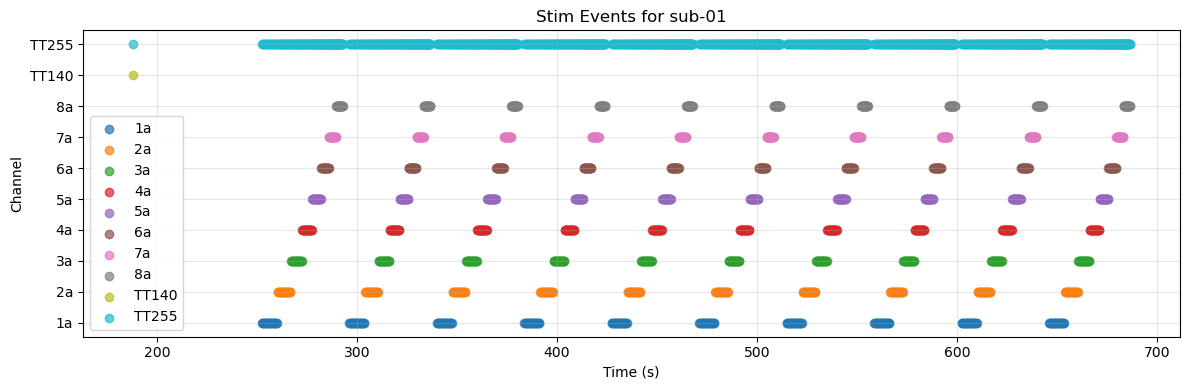

In [6]:
plot_stim_events('sub-01', all_events)

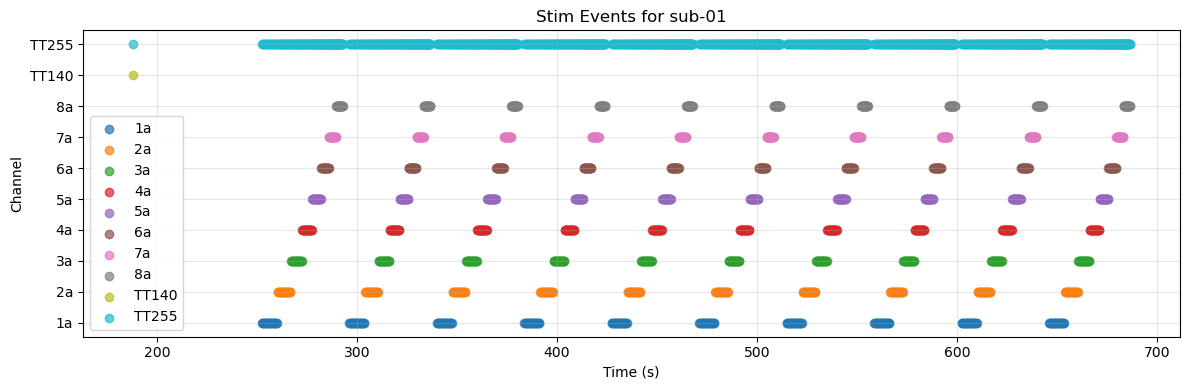

In [7]:
plot_stim_events('sub-01', all_events)

In [8]:
# =============================================================================
# MFF XML EVENT CLEANER 
# =============================================================================

# mff_dir = ""

#cleaned_xml_path = clean_mff_events_with_namespace(
#    mff_directory=mff_dir,
#    trigger_code='TT140'
# )

print(f"\n✅ XML event cleaning complete!")
print(f"Now your .mff file will only load events after first TT140!")


✅ XML event cleaning complete!
Now your .mff file will only load events after first TT140!


In [9]:
# CREATE TRIALS 
merged_events, trials = group_events_into_trials(
    all_events,
    trial_gap_threshold=3.0,
    merge_window=1.0
)


In [10]:
merged_events

,subject,channel,time_sec,sample,sfreq,merged_count,trial_number
0,sub-01,TT140,187.958,93979,500.0,1,0
1,sub-01,TT255,187.966,93983,500.0,1,0
2,sub-01,1a,252.418,126209,500.0,20,1
3,sub-01,TT255,252.426,126213,500.0,160,1
4,sub-01,2a,260.420,130210,500.0,20,1
...,...,...,...,...,...,...,...
907,sub-14,2a,611.754,305877,500.0,20,10
908,sub-14,3a,621.754,310877,500.0,20,10
909,sub-14,4a,629.754,314877,500.0,20,10
910,sub-14,5a,636.420,318210,500.0,20,10


In [11]:
trials = trials[['subject', 'trial_number', 'start_time', 'end_time', 'duration_s']]

In [14]:
# Save trials

trials.to_csv('bima_trials.csv', index=False)
